<a href="https://colab.research.google.com/github/psankesh9/PythonDataScienceHandbook/blob/master/vae_test_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto-encoders for anime faces
Reference: https://learnopencv.com/variational-autoencoder-in-tensorflow/#network-fmnist

In [5]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download splcher/animefacedataset
! unzip animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [6]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
img_height, img_width = 256, 256
batch_size = 128

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'images',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 63565 files belonging to 1 classes.


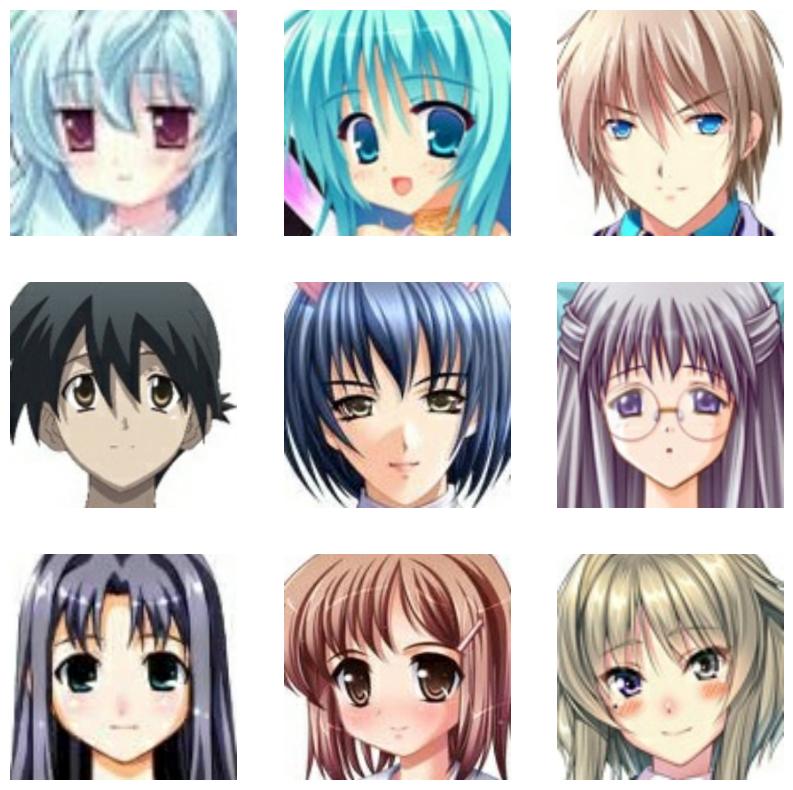

In [10]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [12]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [13]:
print(np.min(first_image), np.max(first_image))

0.00029093426 1.0


In [14]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    #reparametrization trick
    return mean + K.exp(log_var / 2) * epsilon

In [15]:
input_encoder = tuple(first_image.shape)
input_decoder = (200,)

In [16]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    x = layers.Dropout(0.2)(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2D(32, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)


    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [17]:
enc = encoder(input_encoder)

In [18]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 12  3584        ['input_layer[0][0]']            
                                8)                                                                
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 12  512         ['conv_1[0][0]']                 
                                8)                                                          

In [19]:
input_1 = (200,)
input_2 = (200,)

In [20]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [21]:
final = sampling(input_1,input_2)

In [22]:
final.save('sampling-anime.h5')

In [23]:
def decoder(input_decoder):

    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)

    # Block-1
    x = layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2DTranspose(128, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)


    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [24]:
dec = decoder(input_decoder)

In [25]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 32)        0         
                                                           

In [26]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0005) #we can change this optimizer, and the learning rate

In [27]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss_ =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return  r_loss + kl_loss_

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:

        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)


    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)


    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [29]:
os.makedirs('./tf_vae/anime/training_weights', exist_ok=True)
os.makedirs('./tf_vae/anime/images', exist_ok=True)

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            loss_.append(loss)

        #print("Loss",np.mean(loss_))
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/anime/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/anime/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)

        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('./tf_vae/anime/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 256, 256, 3)


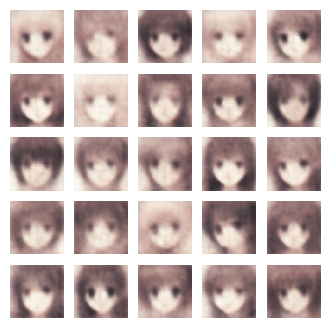

In [32]:
n_epoches=1
is_train=True
if is_train==True:
    train(normalized_ds, n_epoches)

In [33]:
enc.load_weights('./tf_vae/anime/training_weights/enc_'+str(n_epoches-1)+'.h5')

In [34]:
dec.load_weights('./tf_vae/anime/training_weights/dec_'+str(n_epoches-1)+'.h5')

In [35]:
reconstruction_shape = 1000

In [36]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > reconstruction_shape:
        break

4/4 [==============================] - 0s 3ms/step


In [37]:
embeddings.shape

(1024, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

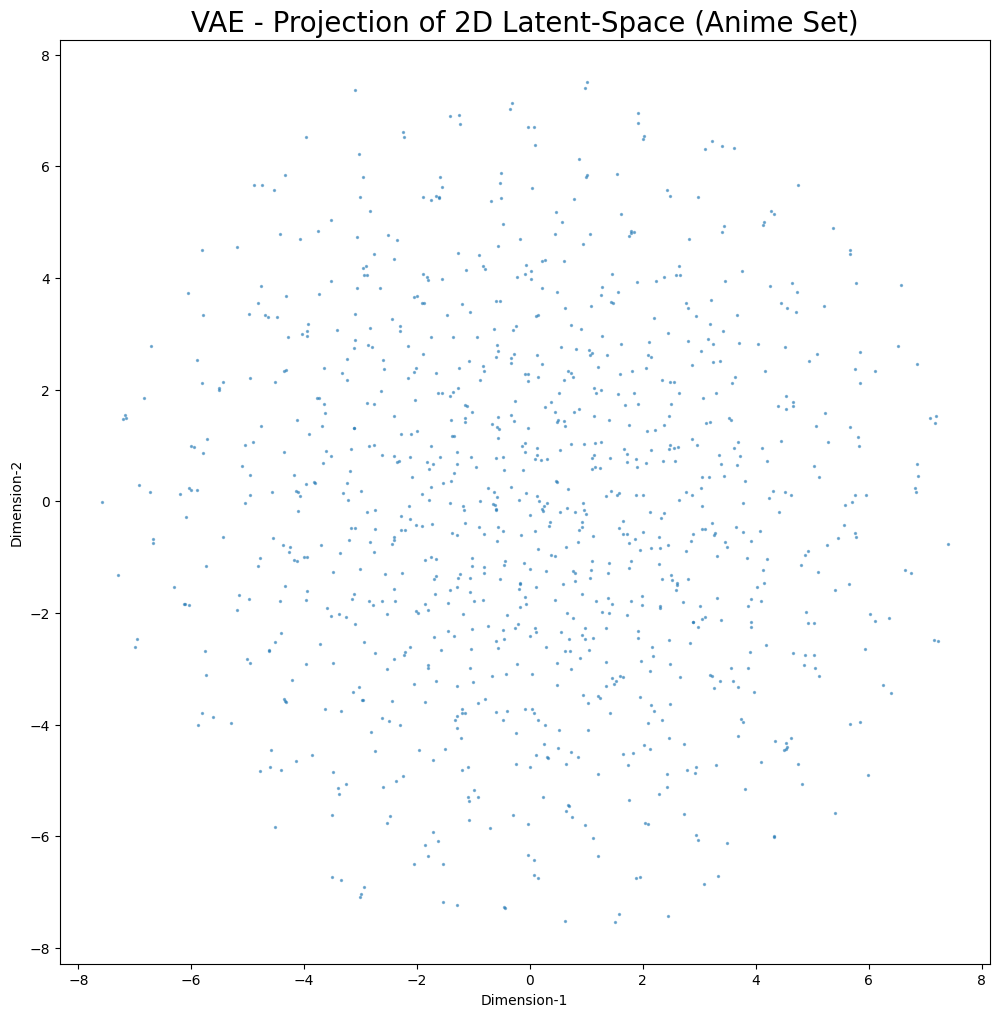

In [38]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=100)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=10)
plt.ylabel("Dimension-2", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space (Anime Set)", size=20)
plt.show()

In [39]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > reconstruction_shape:
        break

4/4 [==============================] - 0s 30ms/step


In [40]:
reconstruction.shape

(1024, 256, 256, 3)

## Reconstructing Test Images

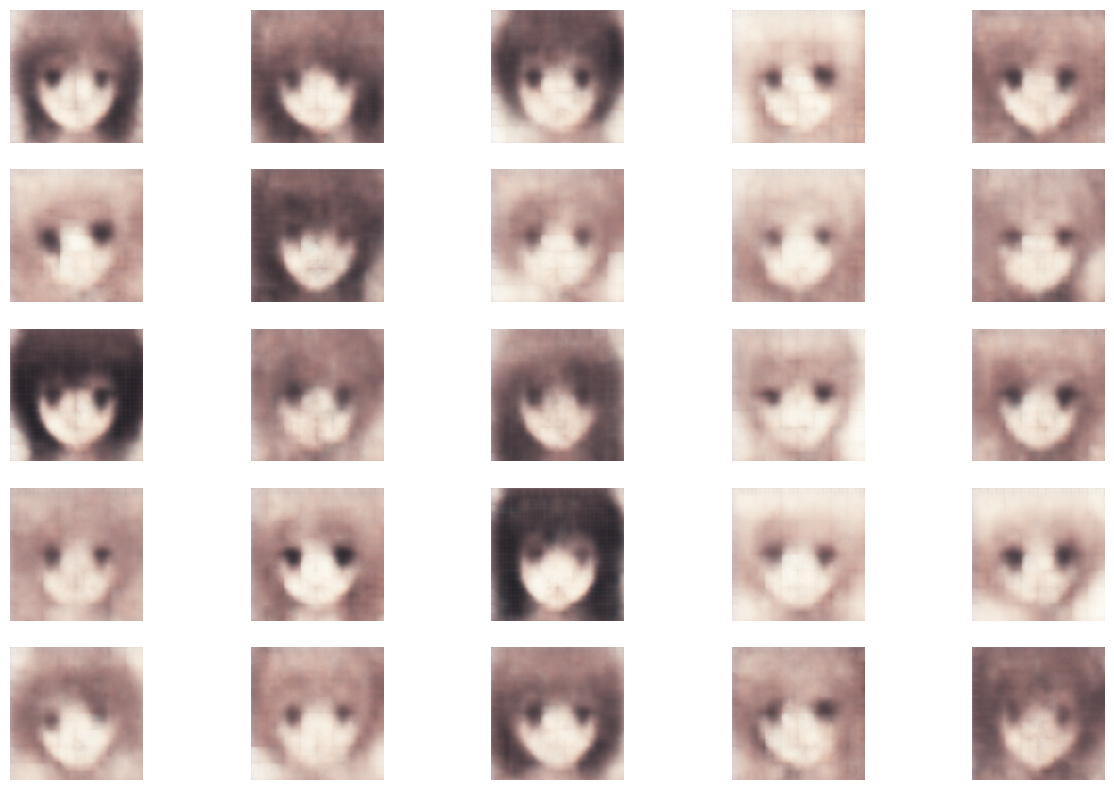

In [41]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)

    ax.imshow(pred)

## Reconstructing Anime Images from a Latent-Vector Sampled with Normal Distribution

1/1 [==============================] - 1s 828ms/step


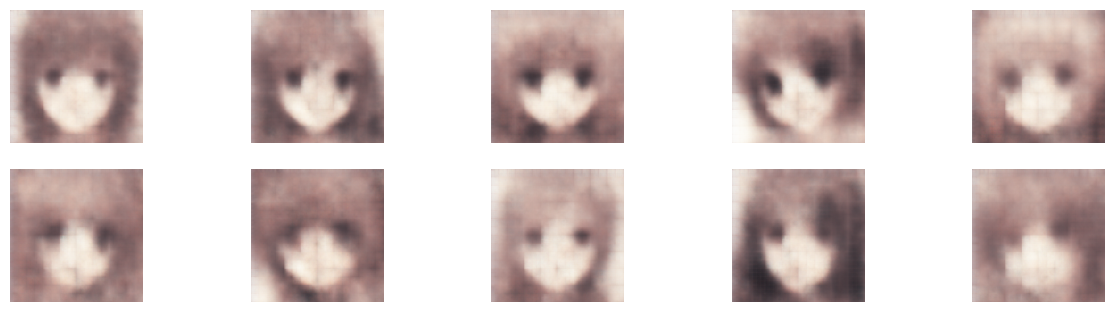

In [42]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

2/2 [==============================] - 1s 651ms/step


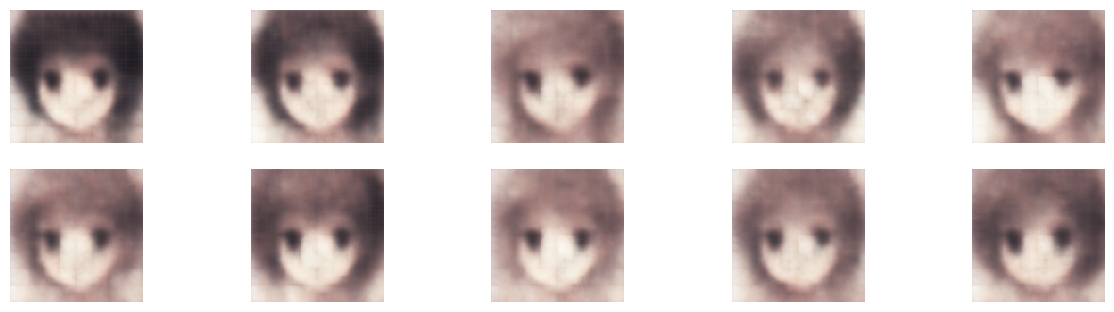

In [43]:
figsize = 15
x = np.random.exponential(scale=0.7, size = (50,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Samples from different ranges

1/1 [==============================] - 0s 21ms/step


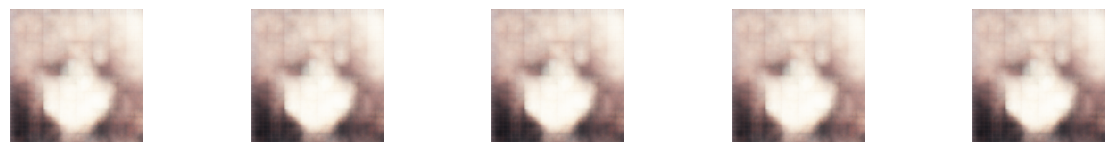

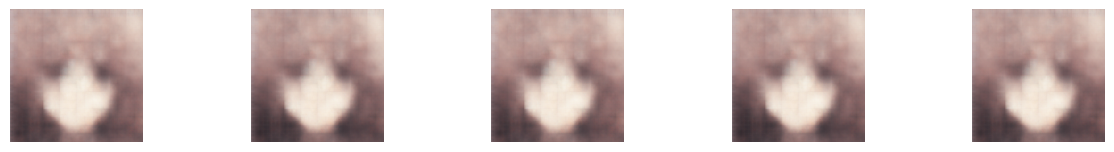

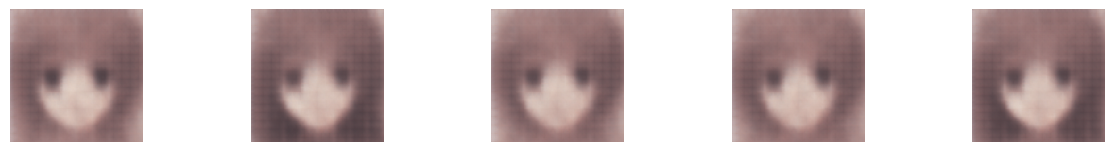

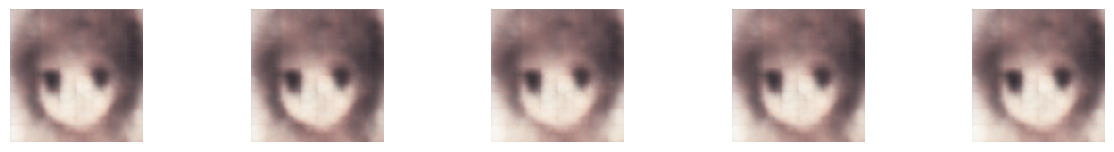

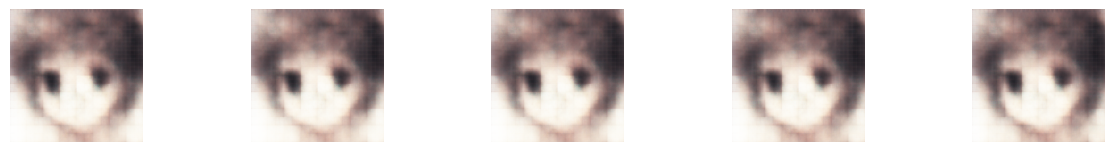

In [44]:
figsize = 15

for var_factor in range(-2, 3, 1):
    min_x = lat_space.min(axis=0)
    max_x = lat_space.max(axis=0)
    x = np.random.uniform(size = (10,200))
    x = x * (max_x - (np.abs(min_x))) + var_factor
    #print("value "+str(var_factor))
    reconstruct = dec.predict(x)


    fig = plt.figure(figsize=(figsize, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.set_label("value "+str(var_factor))

    for i in range(5):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

In [45]:
#!pip uninstall tensorflow-io
!pip install --upgrade --no-deps --force-reinstall tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 34.3 MB/s eta 0:00:00


In [46]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Download Inception model
from tensorflow.keras.applications.resnet50 import ResNet50

# Download ResNet50 model
resnet_model = ResNet50(include_top=False, pooling='avg', input_shape=(224,224,3))


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score


94765736/94765736 [==============================] - 5s 0us/step


In [47]:
# Assume x_input are the input images and x_output are the output images from autoencoder
x_input_resized = tf.image.resize(x_input, (299,299))
x_output_resized = tf.image.resize(x_output, (299,299))

# Compute IS and FID
act1 = inception_model.predict(x_input_resized)
act2 = inception_model.predict(x_output_resized)

# compute inception score
p_yx = np.exp(act2)
is_score = calculate_inception_score(p_yx)

# compute frechet inception distance
fid_score = calculate_fid(act1, act2)

print(f"Inception Score: {is_score}, FID Score: {fid_score}")


NameError: ignored

In [ ]:
!pip install --upgrade --no-deps --force-reinstall tensorflow-io

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Download Inception model
from tensorflow.keras.applications.resnet50 import ResNet50

# Download ResNet50 model
resnet_model = ResNet50(include_top=False, pooling='avg', input_shape=(224,224,3))


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(p_yx, eps=1E-16):
    p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)

    avg_kl_d = np.mean(sum_kl_d)
    is_score = np.exp(avg_kl_d)
    return is_score


In [ ]:
# Assume x_input are the input images and x_output are the output images from autoencoder
x_input_resized = tf.image.resize(x_input, (299,299))
x_output_resized = tf.image.resize(x_output, (299,299))

# Compute IS and FID
act1 = inception_model.predict(x_input_resized)
act2 = inception_model.predict(x_output_resized)

# compute inception score
p_yx = np.exp(act2)
is_score = calculate_inception_score(p_yx)

# compute frechet inception distance
fid_score = calculate_fid(act1, act2)

print(f"Inception Score: {is_score}, FID Score: {fid_score}")
